# Introduction to the General Linear Model (GLM)

In this tutorial we will explore how we can use the general linear model (GLM) to make inferences about brain responses in a single subject.

We will explore the statistics in the context of a simple hypothetical experiment.

I encourage you to watch some short introductory videos on regression by Jeanette Mumford.
 - [Simple Linear Regression](https://www.youtube.com/watch?v=yLgPpmXVVbs)
 - [Matrix Algebra Basics](https://www.youtube.com/watch?v=fkZj8QoYjq8)
 - [Multiple Linear Regression](https://www.youtube.com/watch?v=qdOG7YMolmA)
 - [Hypothesis Testing](https://www.youtube.com/watch?v=ULeg3DH3g9w)
 - [Contrasts in Linear Models](https://www.youtube.com/watch?v=yLgPpmXVVbs&t=631s)
 - [Intepreting Regression Parameters](https://www.youtube.com/watch?v=uClfe4pLrCo)
 - [Mean Centering Regressors](https://www.youtube.com/watch?v=K4S576j90N8)
 
Also, videos from the Principles of fMRI Course by Tor Wager & Martin Lindquist.
 - [GLM](https://www.youtube.com/watch?v=GDkLQuV4he4&list=PLfXA4opIOVrGHncHRxI3Qa5GeCSudwmxM&index=18)
 - [GLM Estimation](https://www.youtube.com/watch?v=Ab-5AbJ8gAs&list=PLfXA4opIOVrGHncHRxI3Qa5GeCSudwmxM&index=23)

First, let's import all of the modules we will need for this tutorial.

(originally created by Luke Chang with significant improvement by Tom Yeh)

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.stats import regress
from nltools.external import glover_hrf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Simulate a voxel time course
To generate an intuition for how we use the GLM to make inferences in fMRI data analysis we will simulate a time series for a single voxel. A simulation means that we will be generating synthetic data that will resemble real data. However, because we know the ground truth of the signal, we can evaluate how well we can recover the true signal using a general linear model.

Imagine that we are interested in what region of the brain is involved in processing faces. We might show a variety of faces to a participant. Each presentation of a face will be a *trial*. Let's simulate what a design might look like with 5 trials of faces.

![faces](faces.png)

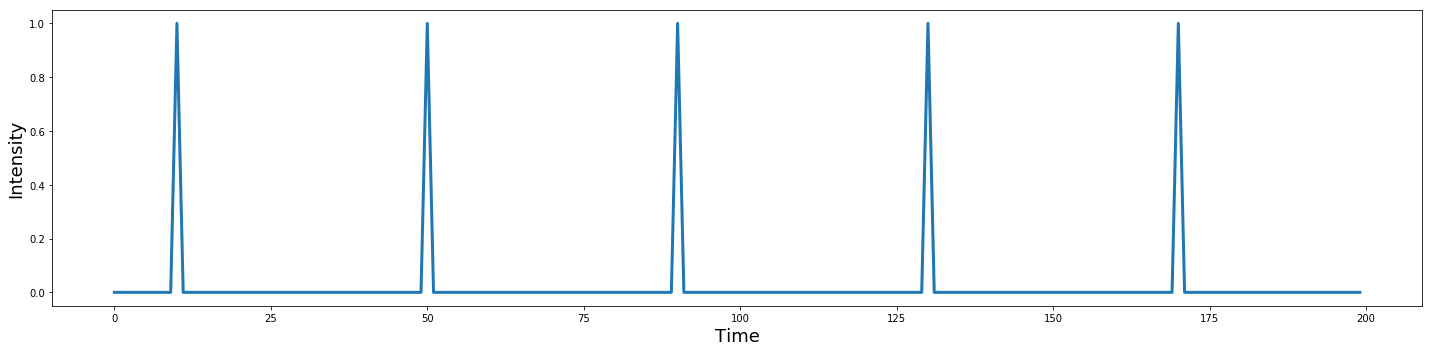

In [2]:
n_tr = 200
n_trial = 5
face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = 1

def plot_timeseries(data, linewidth=3, labels=None):
    plt.figure(figsize=(20,5))
    plt.plot(data, linewidth=linewidth)
    plt.ylabel('Intensity', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    plt.tight_layout()
    if labels is not None:
        plt.legend(labels, fontsize=18)
    
plot_timeseries(face)

We now have 5 events of a 2 second duration where a face is shown. If we scanned someone with this design, we might expect to see any region involved in processing faces, but how would we know which of these regions, if any, *selectively* process faces? Many of the regions we would observe are likely involved in processing *any* visual stimulus.

To rule out this potential confound, we would need at least one other condition that would serve as a visual control. Something that might have similar properties to a face, but isn't a face. 

One possibility is to create a visual stimulus that has all of the same visual properties in terms of luminance and color, but no longer resembles a face. Here is an example of the same faces that have been Fourier transformed, phase-scrambled, and inverse Fourier transformed. These pictures have essentially identical low level visual properties, but are clearly not faces.

![phase](phase_scrambled.png)

However, one might argue that faces are a type of object and regions that are involved in higher visual processing such as object recognition might not be selective to processing faces. In this case, an additional visual control might be objects.

![objects](objects.png)

So clearly we need at least one additional control condition.  Let's make it pictures of objects. 

To demonstrate that a region is processing faces and not simply lower level visual properties or objects more generally, we can search for regions that are selectively more activated in response to viewing faces relative to objects. This is called a *contrast* and is the basic principle of the subtraction method for controlling for potential experimental confounds. Because BOLD fMRI is a relative and not absolute measure of brain activity, the subtraction method is a key aspect of experimental design.

Figures are from Huettel, Song, & McCarthy (2008)

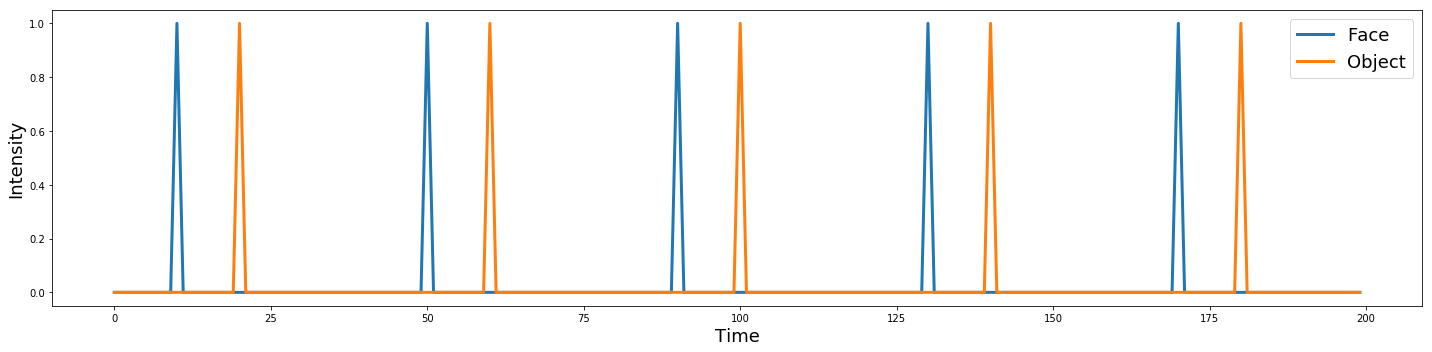

In [3]:
n_tr = 200
n_trial = 5
face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = 1
obj = np.zeros(n_tr)
obj[np.arange(20, n_tr, int(n_tr/n_trial))] = 1
voxel = np.vstack([face,obj]).T

plot_timeseries(voxel, labels=['Face', 'Object'])

Let's imagine that in a voxel processing face specific information we might expect to see a larger activation in response to faces. Maybe two times bigger?

In our simulation, these two values are parameters we are specifying to generate the data. Specifically they refer to the amplitude of the response to Faces and Houses within a particular region of the brain.

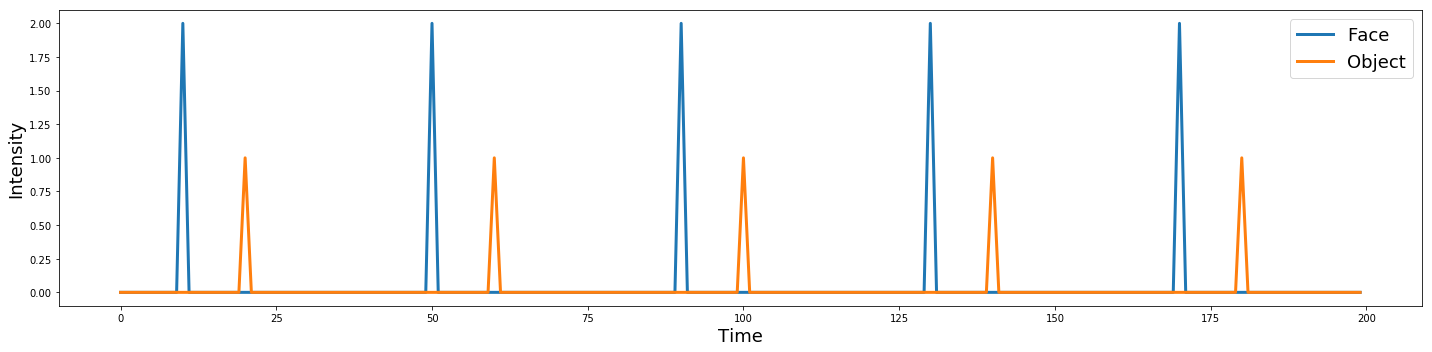

In [4]:
n_tr = 200
n_trial = 5
face_intensity = 2
object_intensity = 1

face = np.zeros(n_tr)
face[np.arange(10, n_tr, int(n_tr/n_trial))] = face_intensity
obj = np.zeros(n_tr)
obj[np.arange(20, n_tr, int(n_tr/n_trial))] = object_intensity
voxel = np.vstack([face,obj]).T

plot_timeseries(voxel, labels=['Face', 'Object'])

Ok, now we have two conditions that are alternating over time. 

We know that the brain has a delayed hemodynamic response to events that has a particular shape, so we will need to convolve these events with an appropriate HRF function. Here, we will use the double-gamma HRF function.

Text(0.5,0,'Time')

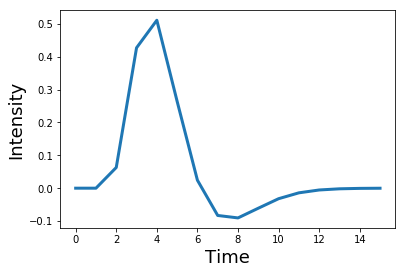

In [5]:
tr = 2
hrf = glover_hrf(tr, oversampling=1)
plt.plot(hrf, linewidth=3)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

We will use `np.convolve` from numpy to perform the convolution.  The length of the convolved data will be the length of the time series plus the length of the kernel minus 1. To make sure everything is the same length, we will chop off the extra time off the convolved time series.

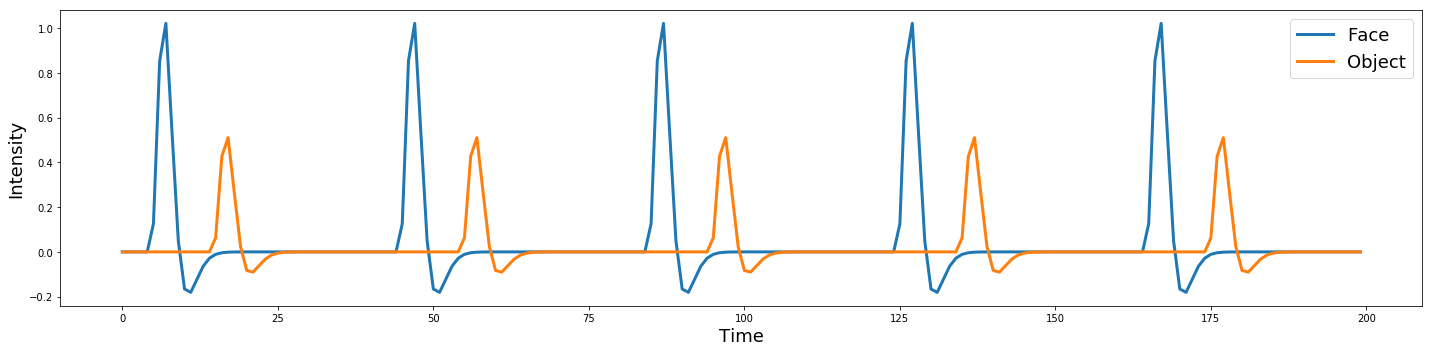

In [6]:
face_conv = np.convolve(face, hrf, mode='same')
obj_conv = np.convolve(obj, hrf, mode='same')
voxel_conv = np.vstack([face_conv, obj_conv]).T

plot_timeseries(voxel_conv, labels=['Face', 'Object'])

While this might reflect the expected HRF response to a single event, real data is much noiser. It is easy to add different types of noise. For example, there might be a low frequency drift, autocorrelation, or possibly some aliased physiological artifacts.

For now, let's start with something simple, like independent white noise drawn from a random Gaussian distribution

$$\epsilon \sim \mathcal{N}(\mu,\,\sigma^{2})$$ 

where $\mu = 0$ and $\sigma = 0.15$

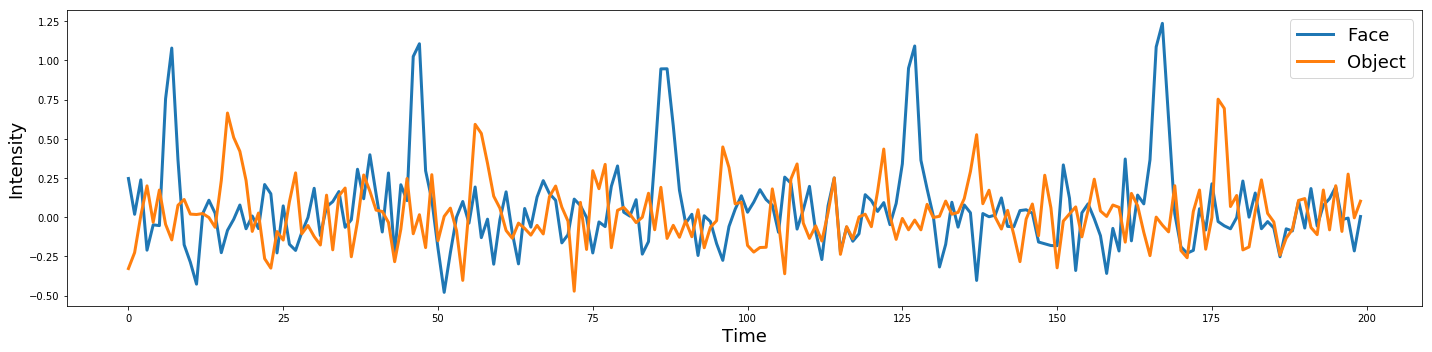

In [7]:
sigma = 0.15
epsilon = sigma*np.random.randn(n_tr, 2)
voxel_conv_noise = voxel_conv + epsilon

plot_timeseries(voxel_conv_noise, labels=['Face', 'Object'])

Now this looks much more like real BOLD activity.

If we were to extract signal from a specific voxel we wouldn't know which condition was which, so let's combine these two signals into a single simulated voxel timeseries by adding the two vectors together with the `.sum()` method.

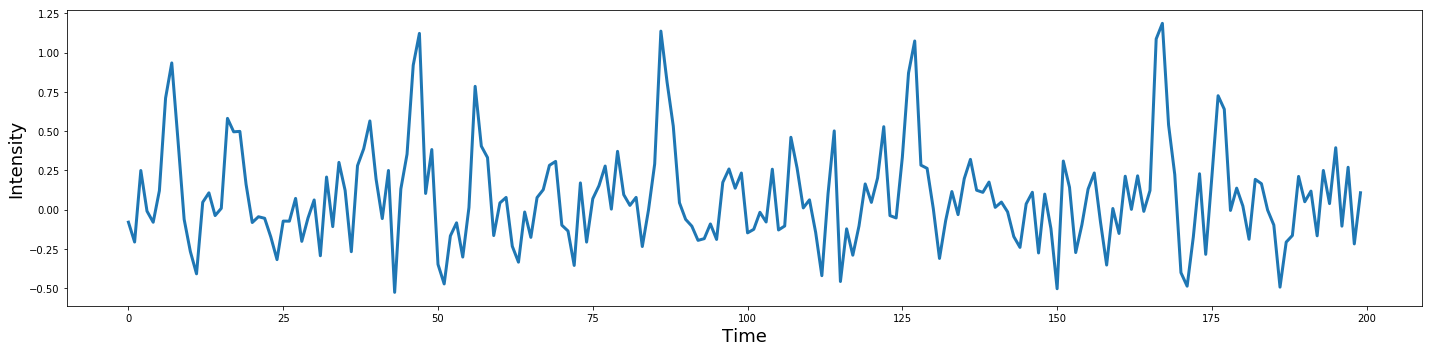

In [8]:
Y = voxel_conv_noise.sum(axis=1)

plot_timeseries(Y)

We can refactor the code above to its own function like below.

In [9]:
def simulate_signal(tr, n_tr, n_trial, stimulus_labels, stimulus_intensities, 
                    interval_between_stimuli, noise_mu, noise_sigma):
    
    np.random.seed(123)
    
    hrf = glover_hrf(tr, oversampling=1)
    
    n_stimuli = len(stimulus_labels)
    
    design_signals = np.zeros((n_tr, n_stimuli))
        
    for i in range(0, len(stimulus_labels)):
        
        intensity = stimulus_intensities[i]
        
        offset = interval_between_stimuli * (i + 1)
            
        design_signals[np.arange(offset, n_tr, int(n_tr/n_trial)), i] = intensity
        
        design_signals[:, i] = np.convolve(design_signals[:, i], hrf, mode='same')
       
    # add noise
    
    sigma = noise_sigma
    epsilon = noise_mu + sigma*np.random.randn(n_tr, n_stimuli)
                        
    signals_with_noise = design_signals + epsilon
        
    # combine separate design signals
    signal = np.sum(signals_with_noise, axis=1)            
    
    return (signal, design_signals) 

# interval = 10
# first task at 10 tr
# second task at 20 tr
# third task at 30 tr 
# ...etc

Let's test `simulate_signal` to generate simulated signals for a variety of design parameters.

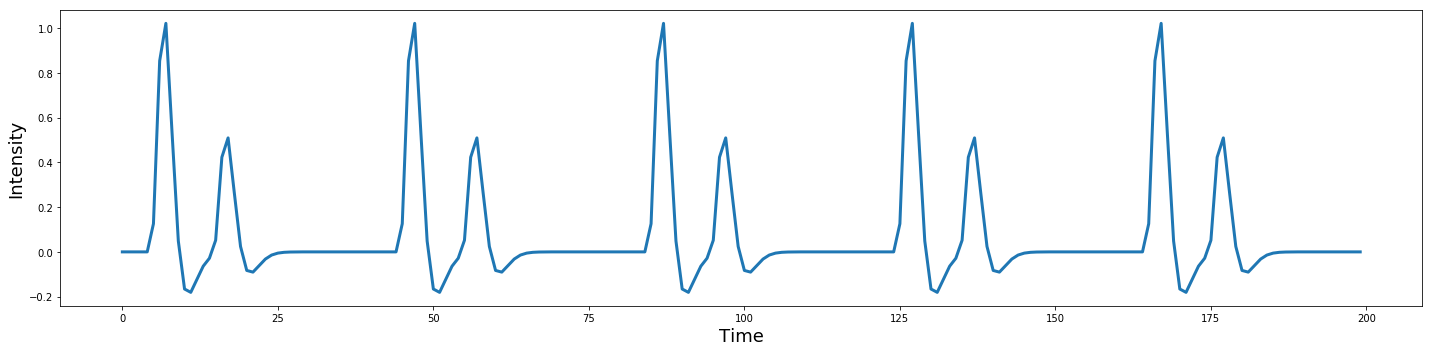

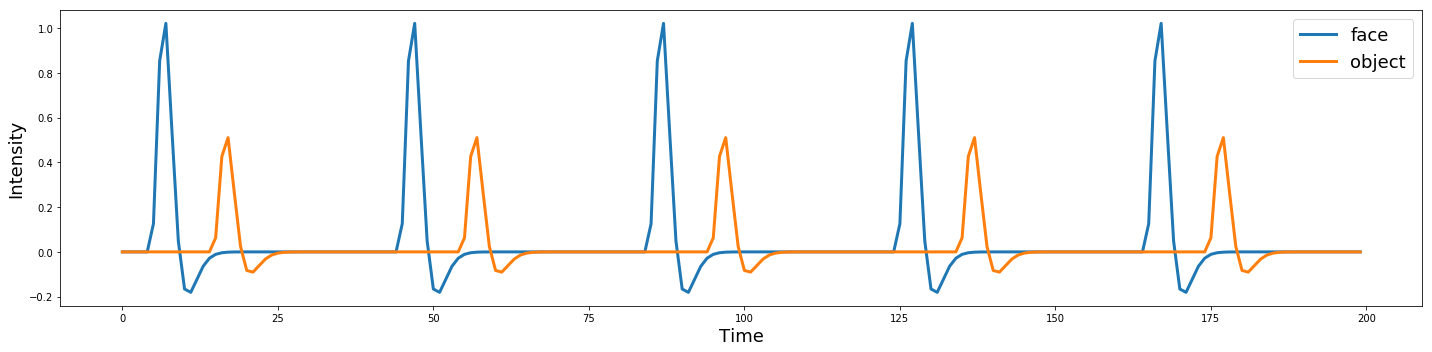

In [10]:
signal, design_signals = simulate_signal(2, 200, 5, ['face', 'object'], [2, 1], 10, 0, 0)
plot_timeseries(signal)
plot_timeseries(design_signals, labels=['face', 'object'])

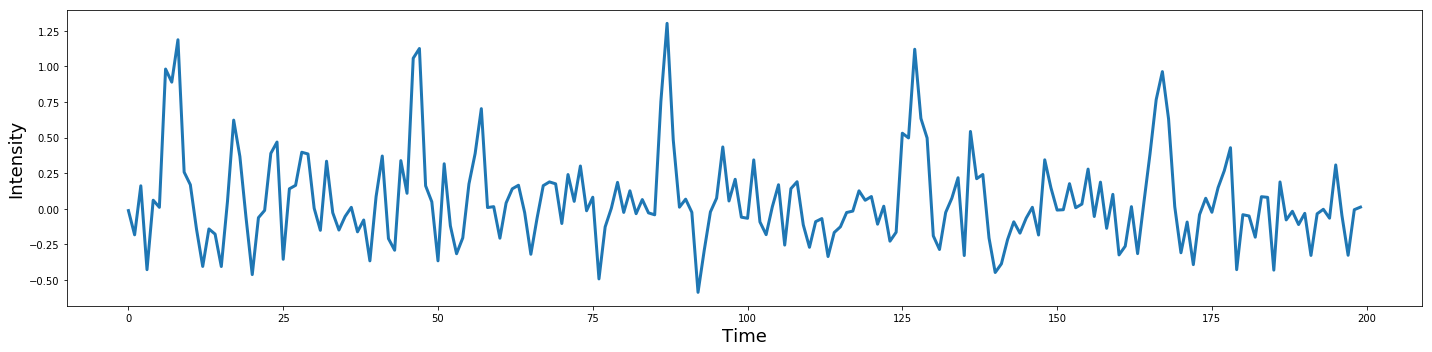

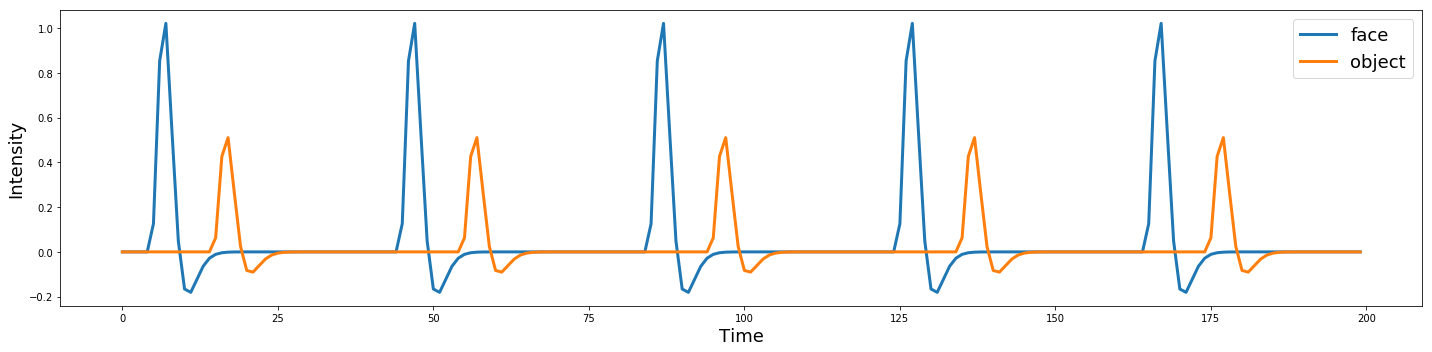

In [11]:
signal, design_signals = simulate_signal(2, 200, 5, ['face', 'object'], [2, 1], 10, 0, 0.15)
plot_timeseries(signal)
plot_timeseries(design_signals, labels=['face', 'object'])

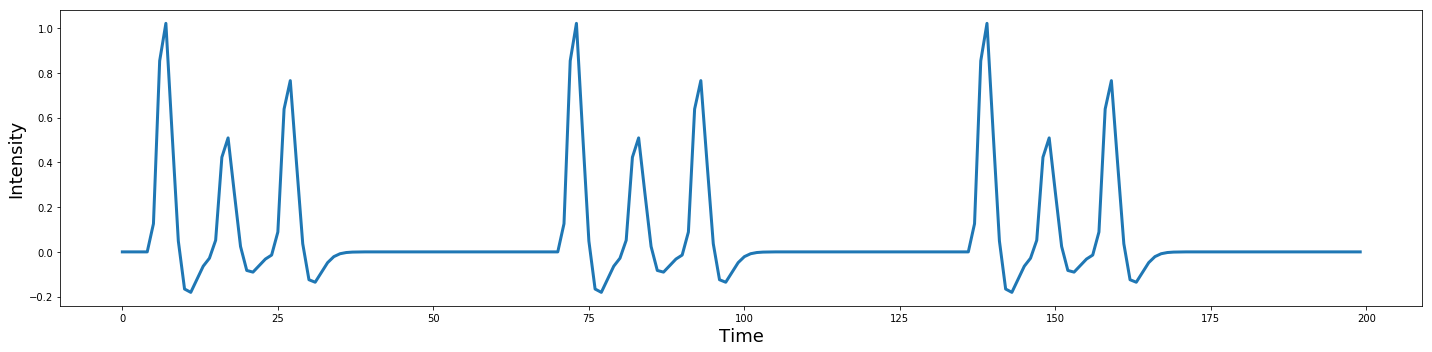

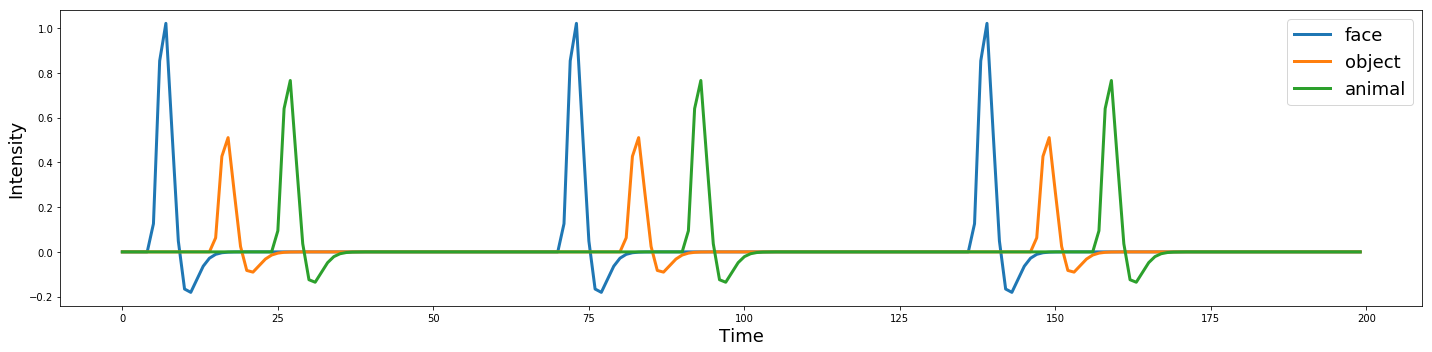

In [12]:
signal, design_signals = simulate_signal(2, 200, 3, ['face', 'object', 'animal'], [2, 1, 1.5], 10, 0, 0)
plot_timeseries(signal)
plot_timeseries(design_signals, labels=['face', 'object','animal'])

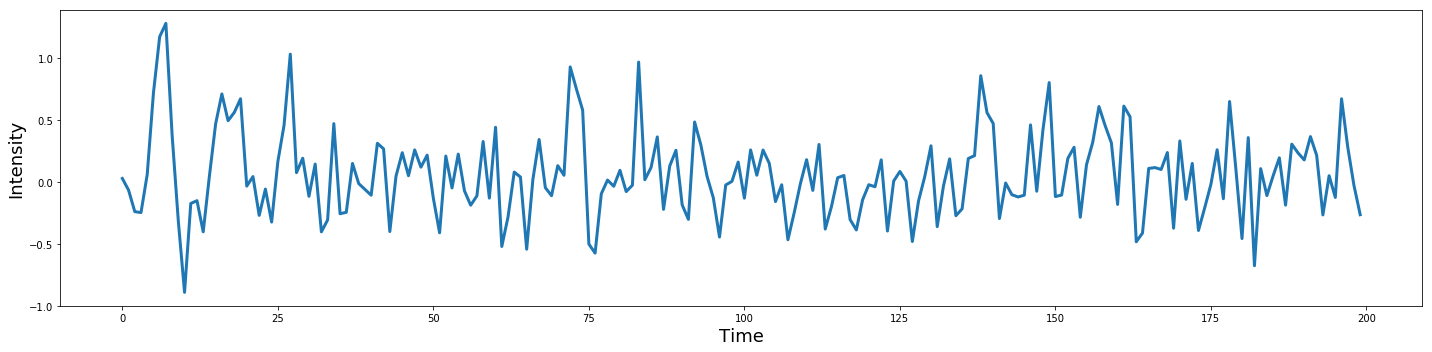

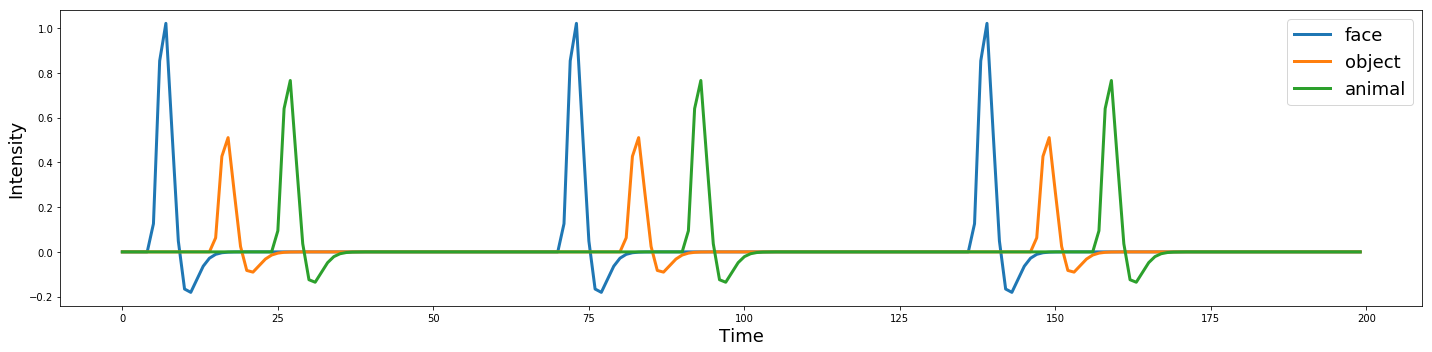

In [13]:
signal, design_signals = simulate_signal(2, 200, 3, ['face', 'object', 'animal'], [2, 1, 1.5], 10, 0, 0.15)
plot_timeseries(signal)
plot_timeseries(design_signals, labels=['face', 'object','animal'])

## Exercise

Improve the signal simulation function by adding the ability to customize the duration of each event. Originally, all events are assumed to take duration exactly one unit. Now we want to allow durations to be any number, such as 5 or 10.

In [14]:
import solutions 
import importlib
importlib.reload(solutions)

def simulate_signal_plus(tr, n_tr, n_trial, stimulus_labels, stimulus_intensities, stimulus_durations,
                    interval_between_stimuli, noise_mu, noise_sigma):
    
#     ### BEGIN SOLUTION
#     signal = []
#     
#     np.random.seed(123)
    
    hrf = glover_hrf(tr, oversampling=1)
    
    n_stimuli = len(stimulus_labels)
    
    design_signals = np.zeros((n_tr, n_stimuli))
        
    for i in range(0, n_stimuli):
        
        intensity = stimulus_intensities[i]
        
        offset = interval_between_stimuli * (i + 1)
        
        stimuli_start_indices = np.arange(offset, n_tr, int(n_tr/n_trial))
        for j in range(0, len(stimuli_start_indices)):
            for k in range(0, stimulus_durations[i]):
                idx = stimuli_start_indices[j] + k
                design_signals[idx, i] = intensity 
        
        design_signals[:, i] = np.convolve(design_signals[:, i], hrf, mode='same')
       
    # add noise
    
    sigma = noise_sigma
    epsilon = noise_mu + sigma*np.random.randn(n_tr, n_stimuli)
                        
    signals_with_noise = design_signals + epsilon
        
    # combine separate design signals
    signal = np.sum(signals_with_noise, axis=1) 
    
    ### END SOLUTION
    
    return (signal, design_signals) 

Below are some examples of the results from the reference implementation.

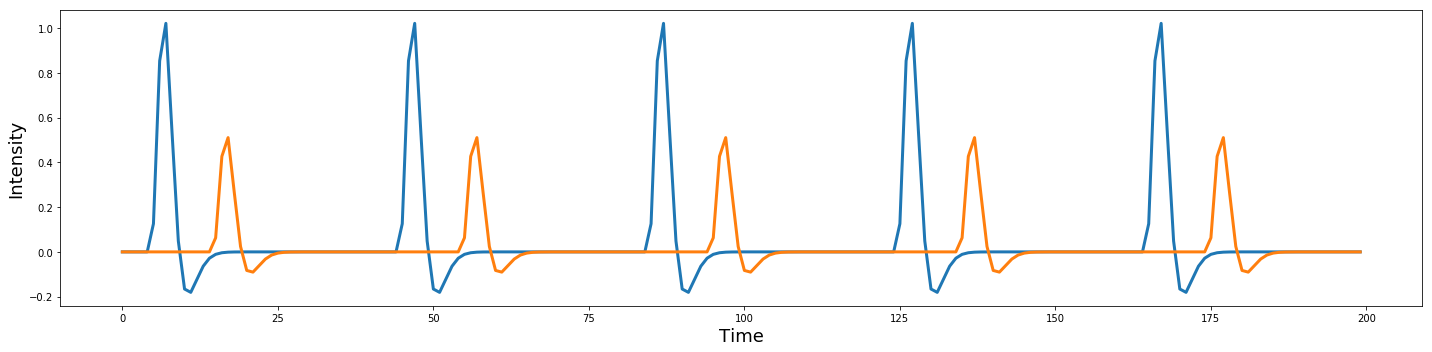

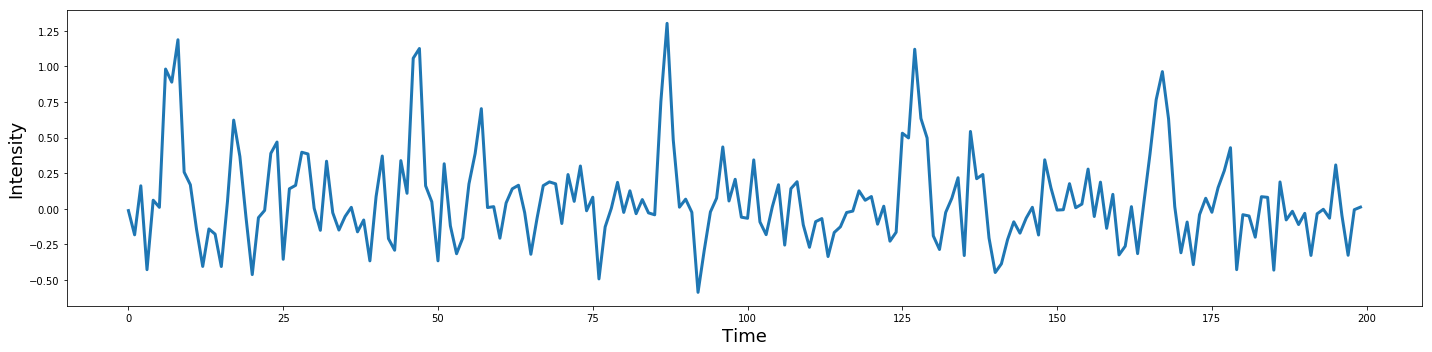

In [15]:
signal, design_signals = solutions.simulate_signal_plus(2, 200, 5, ['face', 'object'], [2, 1], [1, 1], 10, 0, 0.15)
plot_timeseries(design_signals)
plot_timeseries(signal)

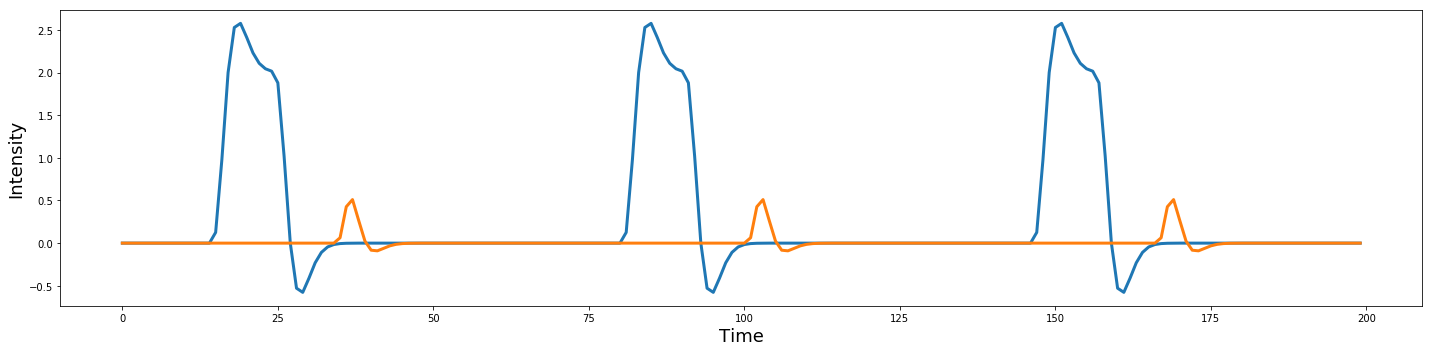

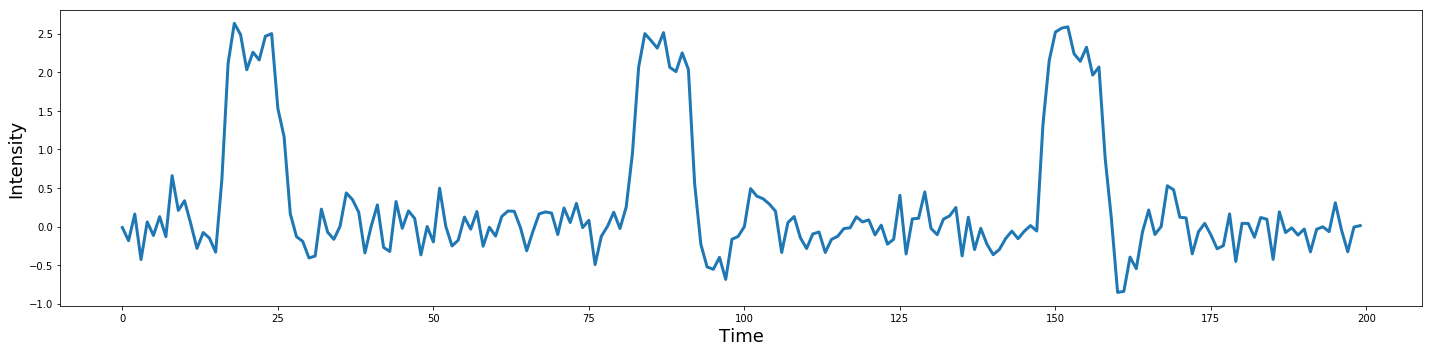

In [16]:
signal, design_signals = solutions.simulate_signal_plus(2, 200, 3, ['face', 'object'], [2, 1], [10, 1], 20, 0, 0.15)
plot_timeseries(design_signals)
plot_timeseries(signal)

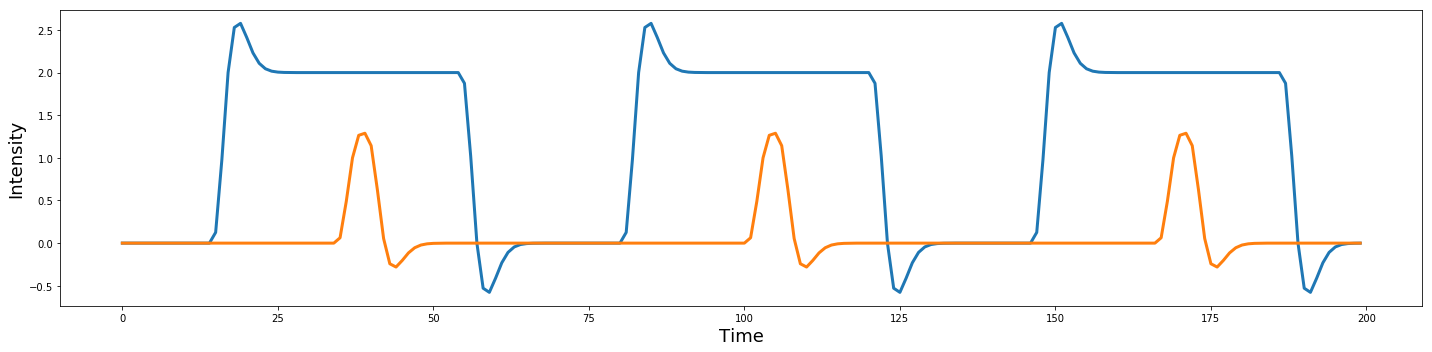

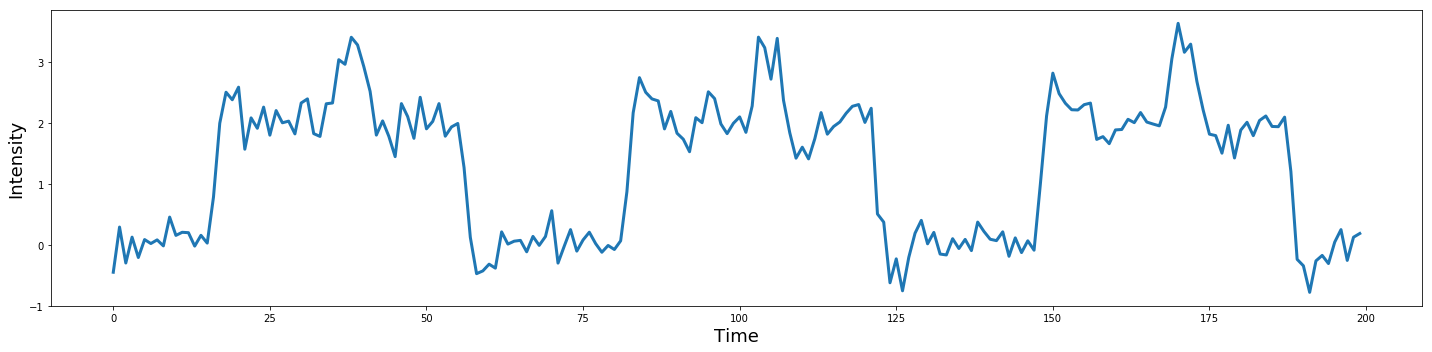

In [49]:
## TEST YOUR SOLUTION

signal, design_signals = simulate_signal_plus(2, 200, 3, ['face', 'object'], [2, 1], [40, 5], 20, 0, 0.15)
plot_timeseries(design_signals)
plot_timeseries(signal)

# Construct Design Matrix

Now that we have our simulated voxel timeseries, let's try and see if we can recover the original signal using a general linear model in the form of:

$$Y = X\beta + \epsilon$$

where $Y$ is our observed voxel time series. $X$ is our model or design matrix, and is where we will specify a predicted response to each condition. $\beta$ is a vector of values that we will estimate to scale our model. $\epsilon$ is independent gaussian noise. This model is linear because we can decompose $Y$ into a set of features r regressors that are scaled by an estimated $\beta$ parameter and summed together. The $\epsilon$ parameter is not usually known and can also be estimated.

You may be wondering how our model is distinct from our simulated data. Remember when we simulated the data we specified 3 parameters - face amplitude, object amplitude, and $\epsilon$, we could have also added a mean, but for now, let's just assume that it is zero. When we fit our model to the simulated data, we will in theory be able to recover these three parameters. 

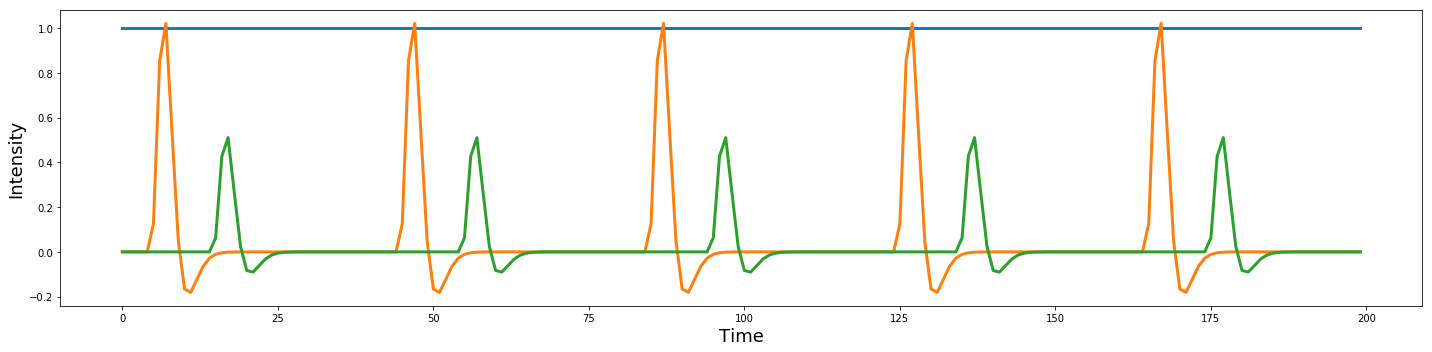

In [18]:
tr = 2
n_tr = 200
n_trial = 5
intercept = np.ones((n_tr, 1))

Y, design_signals = simulate_signal(tr, n_tr, n_trial, ['face', 'object'], [2, 1], 10, 0, 0.15)

X = np.hstack([intercept, design_signals])
plot_timeseries(X)


We can write our model out so that it is very clear what we are doing.

$$Y = \beta_0 \cdot Intercept + \beta_1 \cdot Faces + \beta_2 \cdot Objects + \epsilon$$

We can also make a plot and rotate the timeseries, to better reflect the equation.

It should be clear how each of these components relate to the regression equation.

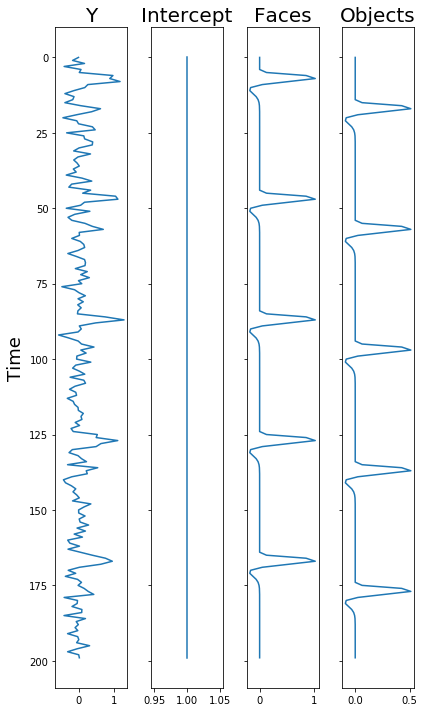

In [19]:
f, a = plt.subplots(ncols=4, figsize=(6, 10), sharey=True)
a[0].plot(np.expand_dims(Y, axis=1), range(len(Y)))
a[1].plot(X[:,0], range(len(Y)))
a[2].plot(X[:,1], range(len(Y)))
a[3].plot(X[:,2], range(len(Y)))
a[0].set_ylabel('Time', fontsize=18)
a[0].set_title('Y', fontsize=20)
a[1].set_title('Intercept', fontsize=20)
a[2].set_title('Faces', fontsize=20)
a[3].set_title('Objects', fontsize=20)
plt.gca().invert_yaxis()
plt.tight_layout()

We can refactor the code above to a function.

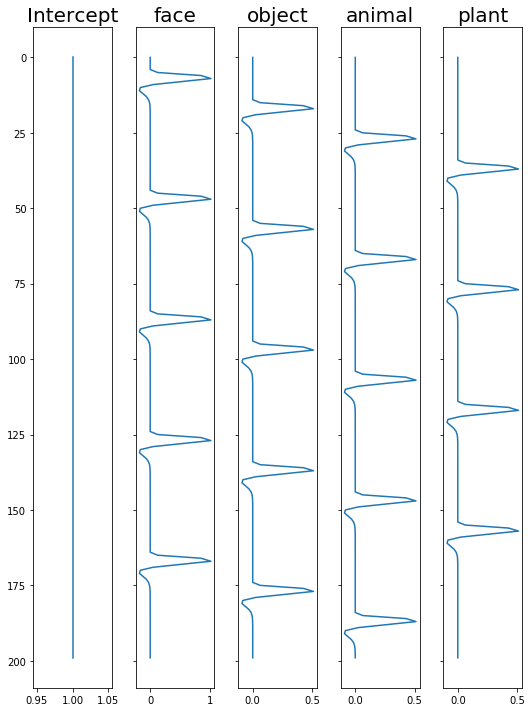

In [20]:
def plot_design_matrix(X, labels):
    m = len(labels)
    f, a = plt.subplots(ncols=m, figsize=(m*1.5, 10), sharey=True)

    for i in range(0, m):        
        label = labels[i]
        a[i].plot(X[:,i], range(len(Y)))
        a[i].set_title(label, fontsize=20)

    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    
Y, design_signals = simulate_signal(tr, n_tr, n_trial, ['face', 'object', 'animals', 'plant'], [2, 1, 1, 1], 10, 0, 0.15)
X = np.hstack([intercept, design_signals])

plot_design_matrix(X, ['Intercept', 'face', 'object', 'animal', 'plant'])

# Estimate GLM

There are several ways to estimate the parameters for our general linear model. The Ordinary Least Squares (OLS) estimator finds the $\hat\beta$ hyperplane that minimizes the error between the observed $Y$ and predicted $\hat Y$. 

This can be formulated using linear algebra as: 

$$\hat{\beta} = (X^T X)^{-1}X^TY$$

There is also maximum likelihood estimator, which is identical to the ordinary least squares estimator, when the error terms are normally distributed.

$$L(\beta, \sigma^2 | Y, X) = \displaystyle \prod_{i=1}^{n}\frac{1}{\sqrt(2\pi\sigma^2)} \cdot e^{-\frac{(Y_i - \beta X_i)^2}{2\sigma^2}}$$

where 

$$\mathcal{N}(0,\sigma^{2})$$

For this class, we will primarily be focusing on the Ordinary Least Squares Estimator. In fact, just to demonstrate that the math is actually relatively straightforward, we will write our own function for the estimator using the linear algebra formulation. In practice, we typically will use a premade function, which is usually slightly more computationally efficient and also will calculate standard errors, etc.

beta Faces - beta Objects: 0.27


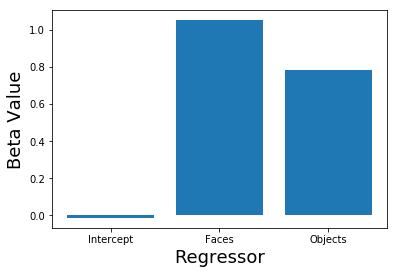

In [21]:
def estimate_beta(X, Y):
    return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)




Y, design_signals = simulate_signal(tr, n_tr, n_trial, ['face', 'object'], [2, 1], 10, 0, 0.15)
X = np.hstack([intercept, design_signals])
beta = estimate_beta(X, Y)

plt.bar(['Intercept','Faces', 'Objects'], beta)
plt.xlabel('Regressor', fontsize=18)
plt.ylabel('Beta Value', fontsize=18)

print('beta Faces - beta Objects: %.2f' % (beta[1]-beta[2]))

We can see that our model is working pretty well. We did not add a mean to the simulated timeseries, so our estimator correctly figures out that the intercept parameter should be zero. The model also correctly figured out that the scaling parameter for the faces regressor was 1 unit higher than the objects regressor.  However, these are sort of centered around the mean. 

Another way to evaluate how well our model is working is to plot our predicted $\hat Y$ on top of our simulated $Y$.

We can quantify the degree to which our model is accurately predicting the observed data by calculating the residual.

$$residual = Y - \hat Y$$

Text(0.5,1,'Residual')

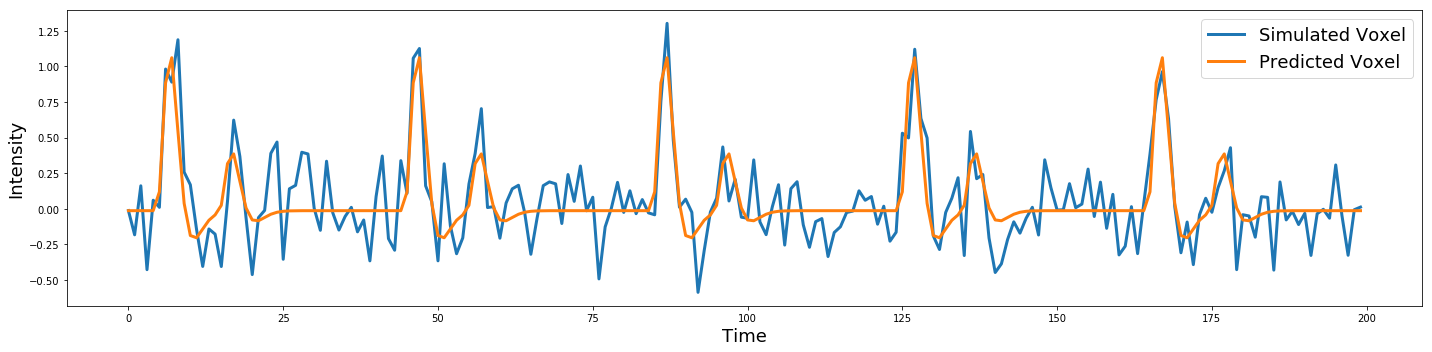

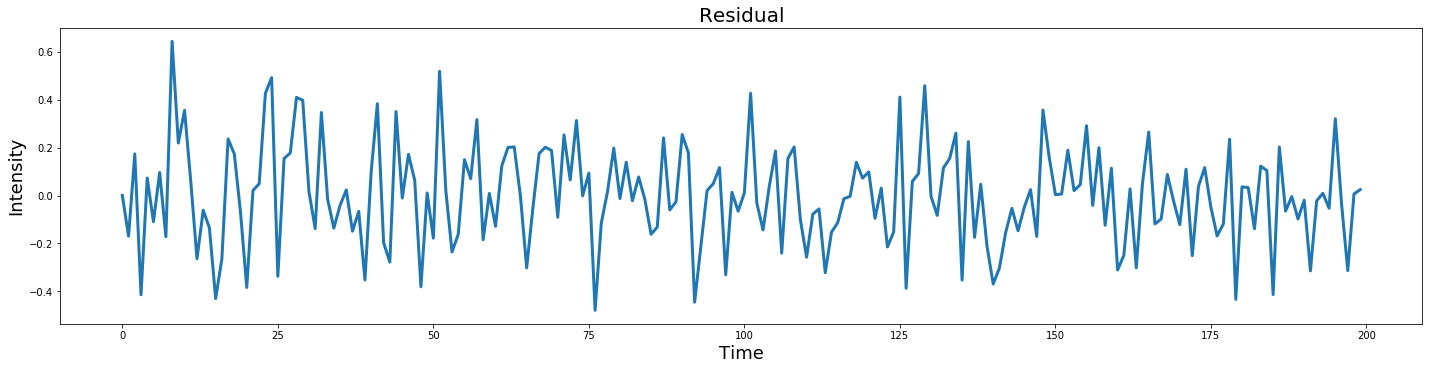

In [22]:
predicted_y = np.dot(X, beta)

predicted_ts = np.vstack([Y, predicted_y]).T

plot_timeseries(predicted_ts, labels=['Simulated Voxel', 'Predicted Voxel'])

residual = Y - predicted_y

plot_timeseries(residual)
plt.title('Residual', fontsize=20)

In [23]:
def glm_analysis_alpha(generate_signal_func):
    
    Y, design_signals = generate_signal_func()
    
    intercept = np.ones((n_tr, 1))
    
    X = np.hstack([intercept, design_signals])
    
    beta = estimate_beta(X, Y)
    
    predicted_y = np.dot(X, beta)

    predicted_ts = np.vstack([Y, predicted_y]).T

    plot_timeseries(predicted_ts, labels=['Simulated Voxel', 'Predicted Voxel'])
    

We can now use this function to test the effect of different argument values easily. For example, let's test different number of trials.

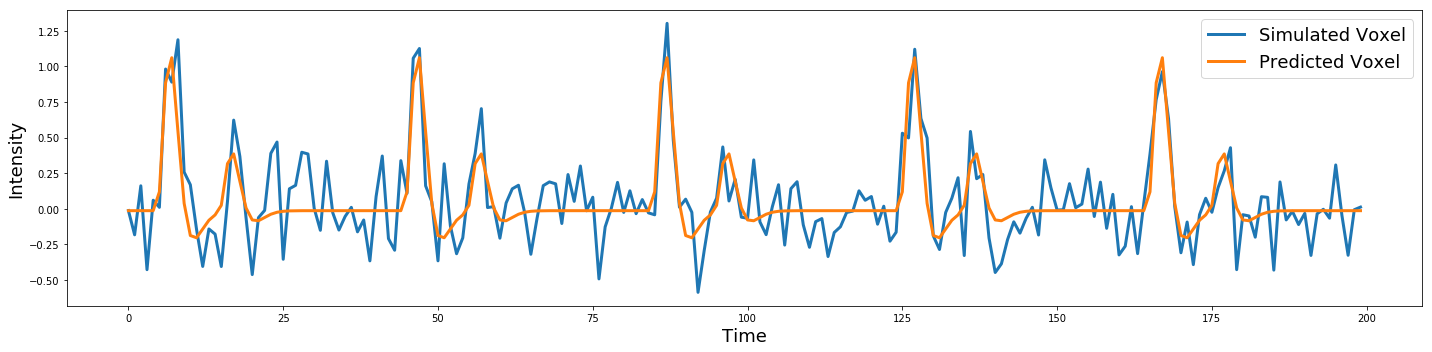

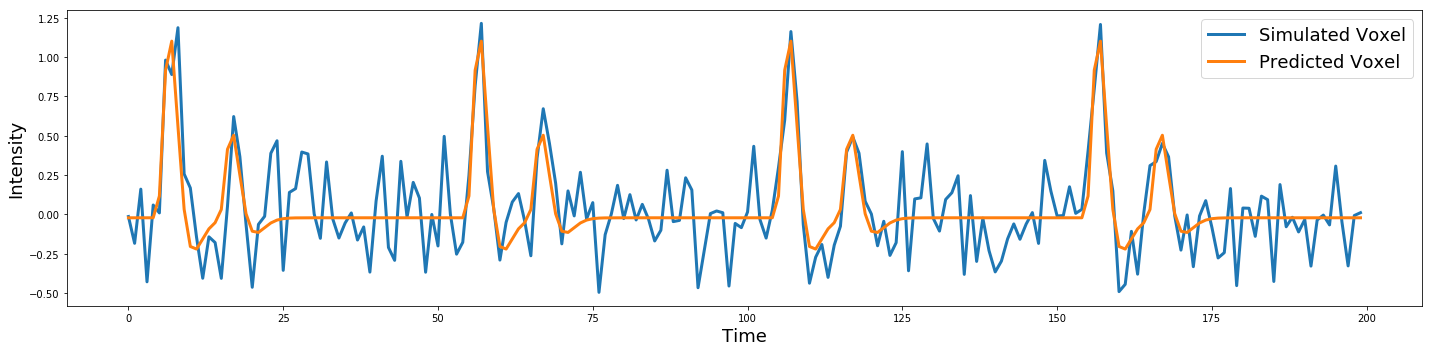

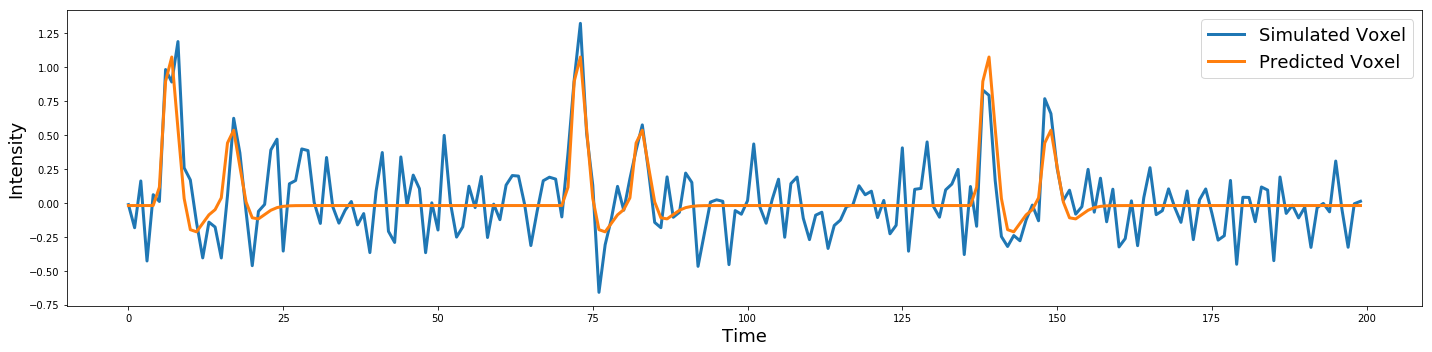

In [24]:
glm_analysis_alpha(lambda : simulate_signal(2, 200, 5, ['face', 'object'], [2, 1], 10, 0, 0.15))

glm_analysis_alpha(lambda : simulate_signal(2, 200, 4, ['face', 'object'], [2, 1], 10, 0, 0.15))

glm_analysis_alpha(lambda : simulate_signal(2, 200, 3, ['face', 'object'], [2, 1], 10, 0, 0.15))

Also, we can test different noise levels.

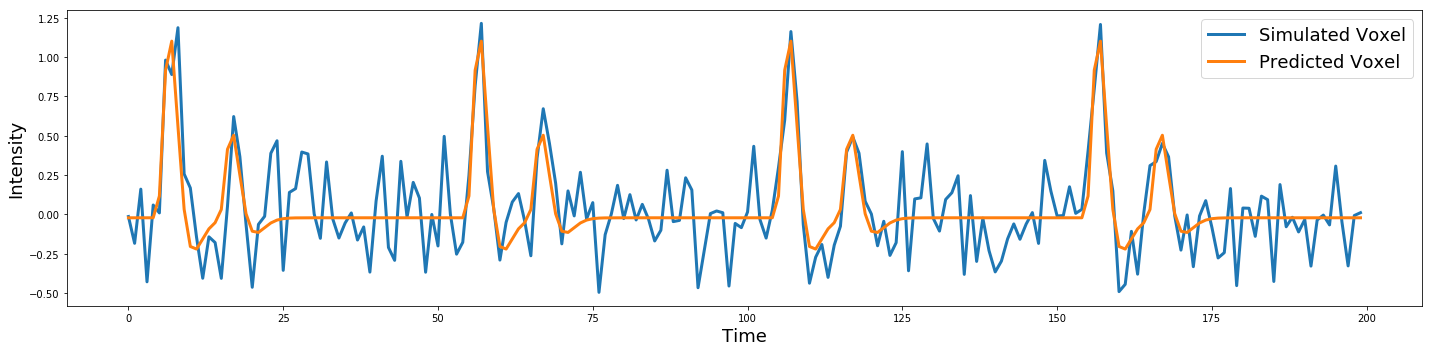

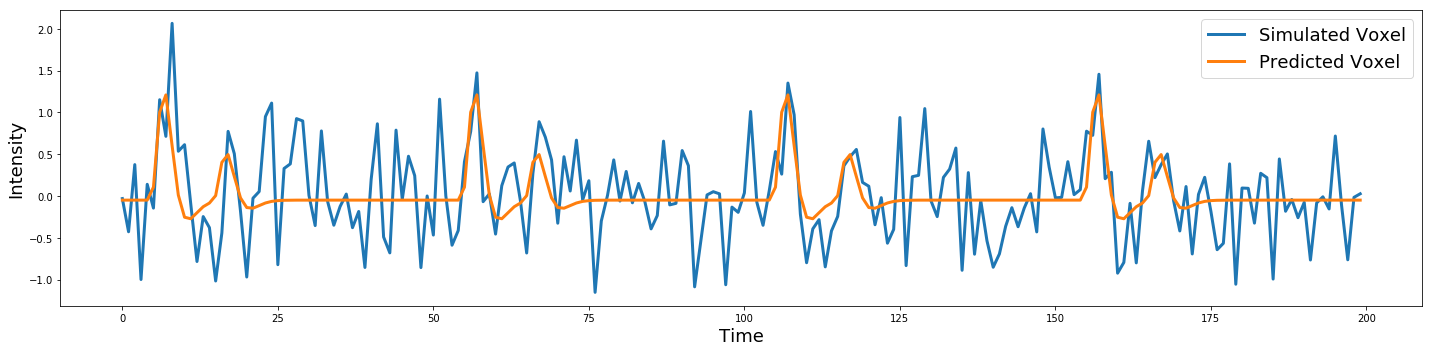

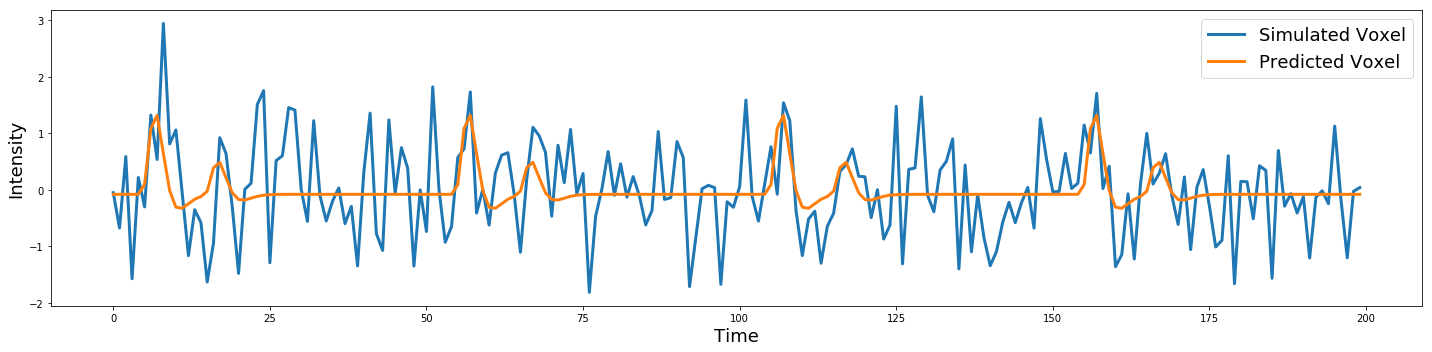

In [25]:
glm_analysis_alpha(lambda : simulate_signal(2, 200, 4, ['face', 'object'], [2, 1], 10, 0, 0.15))

glm_analysis_alpha(lambda : simulate_signal(2, 200, 4, ['face', 'object'], [2, 1], 10, 0, 0.35))

glm_analysis_alpha(lambda : simulate_signal(2, 200, 4, ['face', 'object'], [2, 1], 10, 0, 0.55))

## Standard Errors

As you can see, we are doing a reasonable job recovering the original signals.

You may recall that we specified 3 parameters in our simulation 
 - a $\beta$ weight for faces
 - a $\beta$ weight for objects
 - an $\epsilon$ noise parameter.

The *standard error of the estimate* refers to the standard deviation of the residual.

Formally, this can be described as:

$$\hat \sigma = \sqrt{\frac{\displaystyle \sum_i^n(\hat Y_i - Y_i)^2}{n-k}}$$

where $n$ is the number of observations and $k$ is the total number of regressors. 

This number is essentially an estimate of the overall amount of error in the model or $\epsilon$. This error is assumed to be independent and normally distributed. The smaller the residual variance $\hat\sigma$ the better the fit of the model.

As you can see, the parameter is close, but slightly higher than the one we simulated.  This might be because we have relatively little data in our simulation.

Standard Error of the Estimate: 0.21


(array([10., 15., 23., 36., 52., 30., 17., 11.,  5.,  1.]),
 array([-0.4794969 , -0.3670511 , -0.25460531, -0.14215952, -0.02971373,
         0.08273207,  0.19517786,  0.30762365,  0.42006944,  0.53251523,
         0.64496103]),
 <a list of 10 Patch objects>)

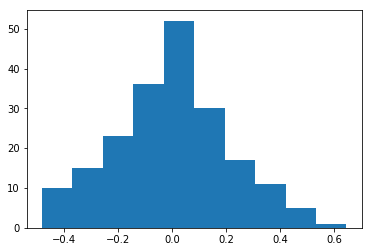

In [26]:
predicted_sigma = np.std(residual)

print("Standard Error of the Estimate: %.2f" % predicted_sigma)

plt.hist(residual)

## Explained Variance

Sometimes we want a single metric to quantify overall how well our model explained the data. There are many metrics that can provide a quantitative measure of *goodness of fit*.

Here we will calculate $R^2$ using the following formula:

$$R^2 = 1 - \frac{\displaystyle \sum_i^n(\hat y_i - y_i)^2}{\displaystyle \sum_i^n(y_i - \bar y)^2}$$

where $y_i$ is the measured value of the voxel at timepoint $i$, $\hat y_i$ is the predicted value for time point $i$, and $\bar y$ is the mean of the measured voxel timeseries.

$R^2$ will lie on the interval between $[0,1]$ and can be interpreted as percentage of the total variance in $Y$ explained by the model, $X$, where 1 is 100% and 0 is none.

In [27]:
def r_square(Y, predicted_y):
    SS_total = np.sum((Y - np.mean(Y))**2)
    SS_residual = np.sum((Y - predicted_y)**2)
    return 1-(SS_residual/SS_total)

r2 = r_square(Y, predicted_y)
print("R^2: %.2f" % r2)

R^2: 0.59


## Standard Error of $\beta$ estimates

We can also estimate the uncertainty of regression coefficients. The uncertainty of the beta parameters is quantified as a standard error around each specific estimate. 

$$\sigma = \sqrt{diag((X^TX)^{-1})} \cdot \hat \sigma$$

This is essentially a confidence interval around the $\beta_j$ estimate. One standard error, $1*\hat \sigma$ is approximately equivalent to a 68% confidence interval, while $2*\hat\sigma$ is approximately a 95% confidence interval.



Text(0,0.5,'Beta Value')

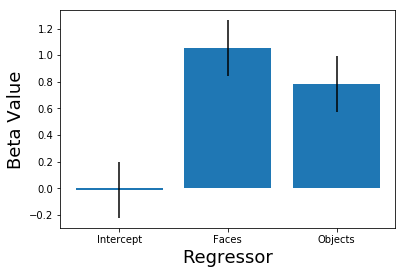

In [28]:
std_error = np.sqrt(np.diag((np.linalg.pinv(np.dot(X.T, X))))) * predicted_sigma

plt.bar(['Intercept','Faces', 'Objects'], beta, yerr = predicted_sigma)
plt.xlabel('Regressor', fontsize=18)
plt.ylabel('Beta Value', fontsize=18)


## Statistical Significance

We could also perform a hypothesis test to evaluate if any of the regressors are statistically different from zero.

This exercise is simply meant to provide parallels to common statistical jargon. In practice, this is actually rarely done in neuroimaging analysis as we are typically more interested in making statistical inferences across the population rather than within a single participant.

The formula for calculating a t-statistic is very simple:

$$t = \frac{\hat \beta_j}{\hat \sigma_j}$$

where $\beta_j$ refers to the estimated parameter for a regressor $j$, and $\sigma_j$ refers to the standard error of regressor $j$.

$t$ values that are more than 2 standard errors away from zero are called *statistically significant*, which basically just means we are more confident that the estimate is stable and not just an artifact of small sample size. In general, we don't recommend reading too much into significance for individual $\beta$ estimates in single subject fMRI analysis.

In [29]:
t = beta/std_error
t

array([-0.88638146, 16.02657293,  5.96953416])

## Contrasts

Contrasts are a very important concept in fMRI data analysis as they provide the statistical inference underlying the subtraction method of making inferences. See this [video](https://www.youtube.com/watch?v=yLgPpmXVVbs) by Jeanette Mumford or this [video](https://www.youtube.com/watch?v=7MibM1ATai4&list=PLfXA4opIOVrGHncHRxI3Qa5GeCSudwmxM&index=20) by Tor Wager & Martin Lindquist for a more in depth overview. 

Contrasts describe a linear combination of variables in a regression model whose coefficients add up to zero. This allows us to flexibly compare different experimental conditions.

For example, suppose we just wanted to know the magnitude of an effect for a single condition, such as the brain response to faces. We would create a contrast code that isolates the effect size (i.e., $\beta$ estimate for the face regressor)

If our GLM, was:

$$Y = \beta_0 \cdot Intercept + \beta_1 \cdot Faces + \beta_2 \cdot Objects$$

then, the corresponding contrast code or vector for faces would be:

[0, 1, 0]

The contrast code for the object condition would be:

[0, 0, 1]

and importantly the contrast *between* the face and object condition would be:

[0, 1, -1]

More simply, we are calculating the magnitude of the effect of the difference between viewing faces and objects in a single voxel.

To make this a little bit more clear, we will show a graphical representation of the design matrix to make it obvious what we are contrasting.


{('[0, 0, 1]', 0.7841067164384131),
 ('[0, 1, -1]', 0.26844974315473624),
 ('[0, 1, 0]', 1.0525564595931494)}

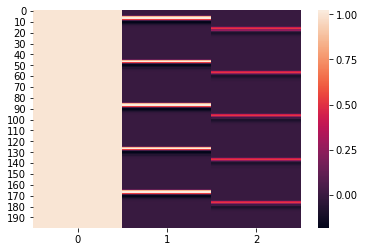

In [30]:
sns.heatmap(X)

c1 = [0, 1, 0]
c2 = [0, 0, 1]
c3 = [0, 1, -1]

{(str(c),np.dot(beta, c)) for c in [c1, c2, c3]}

## Efficiency

We can estimate the efficiency, or the quality of an estimator for a specific experimental design or a hypothesis testing procedure. Efficiency is related to power, or the ability to detect an effect should one exist. However, unlike power, we can estimate efficiency from our design matrix and do not actually need to know the standard error for the model (unlike with power calculations). Specifically, efficiency is defined as the inverse of the sum of the estimator variances. For a more detailed explanation and general experimental design recommendations see this [overview](http://imaging.mrc-cbu.cam.ac.uk/imaging/DesignEfficiency) by Rik Henson, or this [blog post](https://theclevermachine.wordpress.com/tag/fmri-design-efficiency/) on efficiency in experimental designs.

$$e(c\hat\beta) = \frac{1}{c(X^TX)^{-1}c^T}$$

Reducing collinearity or covariance between regressors can increase design efficiency

In [31]:
def contrast_efficiency(X, contrast):
    c = np.array(contrast)
    return 1/(np.dot(np.dot(c, np.linalg.pinv(np.dot(X.T, X))), c.T))

c1 = [0, 1, 0]
c2 = [0, 0, 1]
c3 = [0, 1, -1]

[contrast_efficiency(X, x) for x in [c1, c2, c3]]

[10.214735998476966, 2.5536839996192415, 2.13124350828219]

## Exercise

The expression of $c = [0, 1, 0]$ is quite hard to interpret. Let's write a utility function that can generate a human readible description using the label names.

In [32]:
def get_contrast_description(c, labels):
    ### BEGIN SOLUTION
    positives = []
    negatives = []
    
    for i in range(0,len(c)):
        if (c[i]==1):
            positives.append(labels[i])
        elif (c[i]==-1):
            negatives.append(labels[i])
    
    ### END SOLUTION
    if ((len(positives) > 0) and (len(negatives) > 0)):
        return '+'.join(positives) + ' vs. ' + '+'.join(negatives)
    elif ((len(positives) > 0) and (len(negatives) == 0)):
        return '+'.join(positives)

print(get_contrast_description([0, 1, 0], ['intercept', 'face', 'object'])) 
# => face

print(get_contrast_description([0, 1, -1], ['intercept', 'face', 'object'])) 
# => face vs. object

print(get_contrast_description([0, 1, 0, -1], ['intercept', 'face', 'object', 'animal'])) 
# => face vs. animal

print(get_contrast_description([0, 1, -1, -1], ['intercept', 'face', 'object', 'animal'])) 
# => face vs. object+animal

print(get_contrast_description([0, 1, 1, -1], ['intercept', 'face', 'object', 'animal'])) 
# => face+object vs. animal

face
face vs. object
face vs. animal
face vs. object+animal
face+object vs. animal


In [33]:
# Solutions
importlib.reload(solutions)
print(solutions.get_contrast_description([0, 1, 0], ['intercept', 'face', 'object']))
print(solutions.get_contrast_description([0, 1, -1], ['intercept', 'face', 'object']))
print(solutions.get_contrast_description([0, 1, 0, -1], ['intercept', 'face', 'object', 'animal']))
print(solutions.get_contrast_description([0, 1, -1, -1], ['intercept', 'face', 'object', 'animal']))
print(solutions.get_contrast_description([0, 1, 1, -1], ['intercept', 'face', 'object', 'animal']))


face
face vs. object
face vs. animal
face vs. object+animal
face+object vs. animal


# Pretty Table

Let's learn to use a template library to generate pretty HTML tables to display some results. First, install the mako template engine.

In [34]:
import sys
# !conda install --yes --prefix {sys.prefix} mako

In [35]:
from IPython.display import display, HTML
from mako.template import Template
template = """
<table>
    % for b, label in zip(beta, labels):
        <tr>
            <td>${label}</td>
            <td>${b}</td>
        </tr>
    % endfor
</table>
"""
html = Template(template).render(beta=beta, labels=['intercept', 'face', 'object'])
display(HTML(html))

intercept,-0.013816732690617669
face,1.0525564595931494
object,0.7841067164384131


## Exercise

Now it's your turn to write code to generate an HTML table to display another piece of information---contrast efficiencies.

In [36]:
c1 = [0, 1, 0]
c2 = [0, 0, 1]
c3 = [0, 1, -1]
contrasts = [c1, c2, c3]
labels = ['intercept', 'face', 'object']
contrast_efficiencies = [contrast_efficiency(X, x) for x in contrasts]


def generate_contrast_efficiencies_html(contrasts, labels, contrast_efficiencies):
    ### BEGIN SOLUTION
    descriptions = []
    for i in range(0,len(contrasts)):
        c = contrasts[i]
        descriptions.append(get_contrast_description(c, labels))
                            
    template = """
    <table>
        % for b, desc in zip(contrast_efficiencies, descriptions):
            <tr>
                <td>${desc}</td>
                <td>${b}</td>
            </tr>
        % endfor
    </table>
    """
    
    ### END SOLUTION
    return Template(template).render(contrast_efficiencies=contrast_efficiencies, descriptions=descriptions)

In [37]:
html = generate_contrast_efficiencies_html(contrasts, labels, contrast_efficiencies)
print(html)
display(HTML(html))


    <table>
            <tr>
                <td>face</td>
                <td>10.214735998476966</td>
            </tr>
            <tr>
                <td>object</td>
                <td>2.5536839996192415</td>
            </tr>
            <tr>
                <td>face vs. object</td>
                <td>2.13124350828219</td>
            </tr>
    </table>
    


face,10.214735998476966
object,2.5536839996192415
face vs. object,2.13124350828219


In [38]:
# solution
importlib.reload(solutions)
html = solutions.generate_contrast_efficiencies_html(contrasts, labels, contrast_efficiencies)
print(html)
display(HTML(html))


<table>
        <tr>
            <td>face</td>
            <td>10.215</td>
        </tr>
        <tr>
            <td>object</td>
            <td>2.554</td>
        </tr>
        <tr>
            <td>face vs. object</td>
            <td>2.131</td>
        </tr>
</table>



face,10.215
object,2.554
face vs. object,2.131


In [39]:
importlib.reload(solutions)

html = solutions.generate_results_html(labels, contrasts, beta, r2, contrast_efficiencies)

print(html)
display(HTML(html))


<table>
    <tr>
        <td><b>beta</b></td>
        <td>
<table>
        <tr>
            <td>intercept</td>
            <td>-0.014</td>
        </tr>
        <tr>
            <td>face</td>
            <td>1.053</td>
        </tr>
        <tr>
            <td>object</td>
            <td>0.784</td>
        </tr>
</table>
</td>
    </tr>
    <tr>
        <td><b>r2</b></td>
        <td>0.586</td>
    </tr>    
    <tr>
        <td><b>contrast efficiencies</b></td>
        <td>
<table>
        <tr>
            <td>face</td>
            <td>10.215</td>
        </tr>
        <tr>
            <td>object</td>
            <td>2.554</td>
        </tr>
        <tr>
            <td>face vs. object</td>
            <td>2.131</td>
        </tr>
</table>
</td>
    </tr>
</table>



# Experimental Design

Let's use the simulation to answer questions we might have about experimental design. We might be wondering:

- What happens when we vary the signal amplitude?
- What happens when we vary the noise?
- How many trials do we need?
- What is the impact of the stimulus duration?

## Exercise

Implement `glm_analysis_beta` that improves upon `glm_analysis_alpha` by reporting a set of useful statistics explained above, including $\beta$, $R^2$, predicated $\sigma$, $t$, and contrast efficiencies. In addition, it takes a keyword argument `plot` (default = False) to indicate whether or not to plot figures to visualize the analysis.

In [40]:
# Necessary redefinition to tell the notebook "r_square" isn't an int (grrrr dynamic typing...)
def r_square(Y, predicted_y):
    SS_total = np.sum((Y - np.mean(Y))**2)
    SS_residual = np.sum((Y - predicted_y)**2)
    return 1-(SS_residual/SS_total)

def glm_analysis_beta(generate_signal_func, contrasts, plot = False):
    ### BEGIN SOLUTION
    Y, design_signals = generate_signal_func()
    
    intercept = np.ones((n_tr, 1))
    
    X = np.hstack([intercept, design_signals])
    
    # Beta
    beta = estimate_beta(X, Y)
    
    predicted_y = np.dot(X, beta)
    
    # R squared
    r2 = r_square(Y, predicted_y)

    predicted_ts = np.vstack([Y, predicted_y]).T
    
    # Predicted sigma
    residual = Y - predicted_y
    predicted_sigma = np.std(residual)
    
    # t
    std_error = np.sqrt(np.diag((np.linalg.pinv(np.dot(X.T, X))))) * predicted_sigma
    t = beta/std_error
    
    # Contrast efficiencies
    contrast_effs = contrast_efficiency(X, contrasts)

    if (plot==True):
        plot_timeseries(predicted_ts, labels=['Simulated Voxel', 'Predicted Voxel'])
    
    return (beta,r2,predicted_sigma,t,contrast_effs)
    ### END SOLUTION
    

[-0.01381673  1.05255646  0.78410672] 0.5862102380347538 0.20990283778665733 [-0.88638146 16.02657293  5.96953416] [[10.214736   98.62287624 11.39495347]
 [98.62287624  2.553684   -2.6215653 ]
 [11.39495347 -2.6215653   2.13124351]]


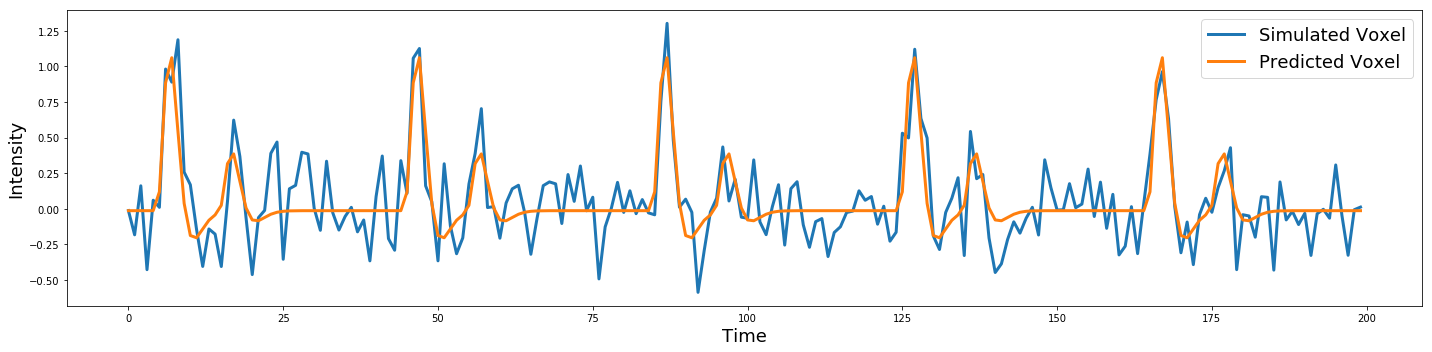

In [41]:
c1 = [0, 1, 0]
c2 = [0, 0, 1]
c3 = [0, 1, -1]
contrasts = [c1, c2, c3]

beta, r_square, predicted_sigma, t, contrast_efficiencies = glm_analysis_beta(
    lambda : simulate_signal(2, 200, 5, ['face', 'object'], [2, 1], 10, 0, 0.15), 
    contrasts,
    plot=True)
print(beta, r_square, predicted_sigma, t, contrast_efficiencies)

In [44]:
html = solutions.generate_results_html(['intercept','face','object'], contrasts, beta, r_square, contrast_efficiencies)
display(HTML(html))

[-0.01381673  1.05255646  0.78410672] 0.5862102380347538 0.20990283778665733 [-0.88638146 16.02657293  5.96953416] [10.214735998476966, 2.5536839996192415, 2.13124350828219]


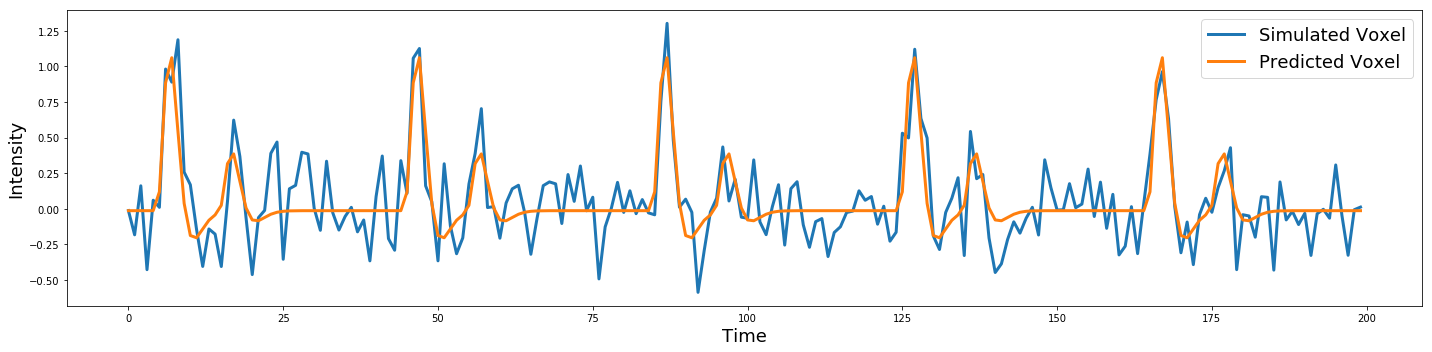

In [42]:
# solution
importlib.reload(solutions)

c1 = [0, 1, 0]
c2 = [0, 0, 1]
c3 = [0, 1, -1]
contrasts = [c1, c2, c3]

beta, r_square, predicted_sigma, t, contrast_efficiencies = solutions.glm_analysis_beta(
    lambda : simulate_signal(2, 200, 5, ['face', 'object'], [2, 1], 10, 0, 0.15), 
    contrasts,
    plot=True)
print(beta, r_square, predicted_sigma, t, contrast_efficiencies)

In [46]:
html = solutions.generate_results_html(['intercept','face','object'], contrasts, beta, r2, contrast_efficiencies)
display(HTML(html))

## number of trials vs. contrast efficiences

A common question in experimental design is determining the optimal number of trials. We can evaluate how different numbers of trials might impact the contrast efficiency. You should be able to use your implementation of `glm_analysis_beta` and `generate_results_html` for this purpose. In other words, remove `solutions.` from the code cell below and make sure you still get similar results.

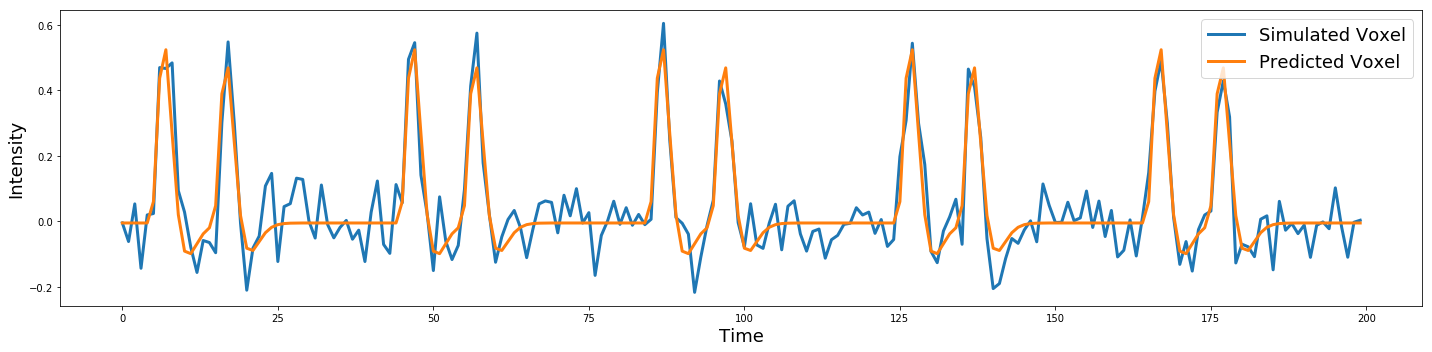

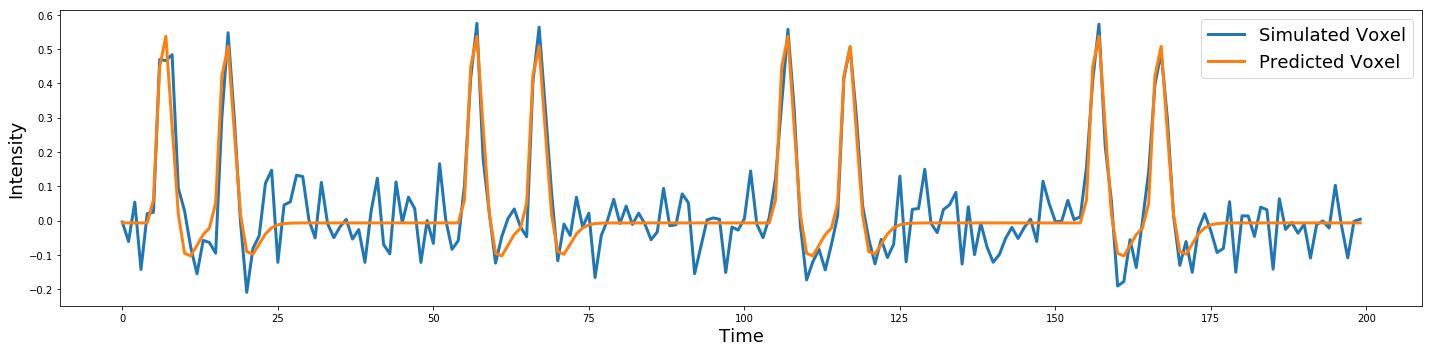

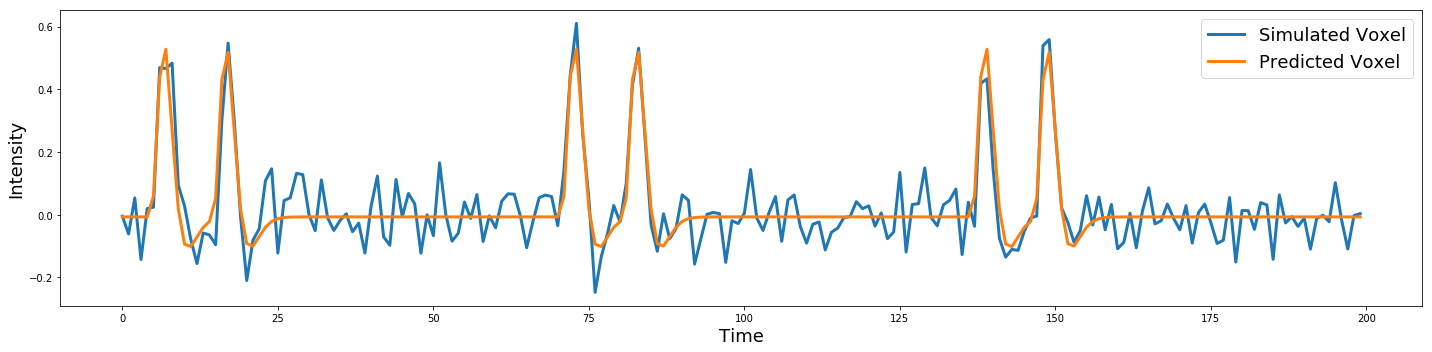

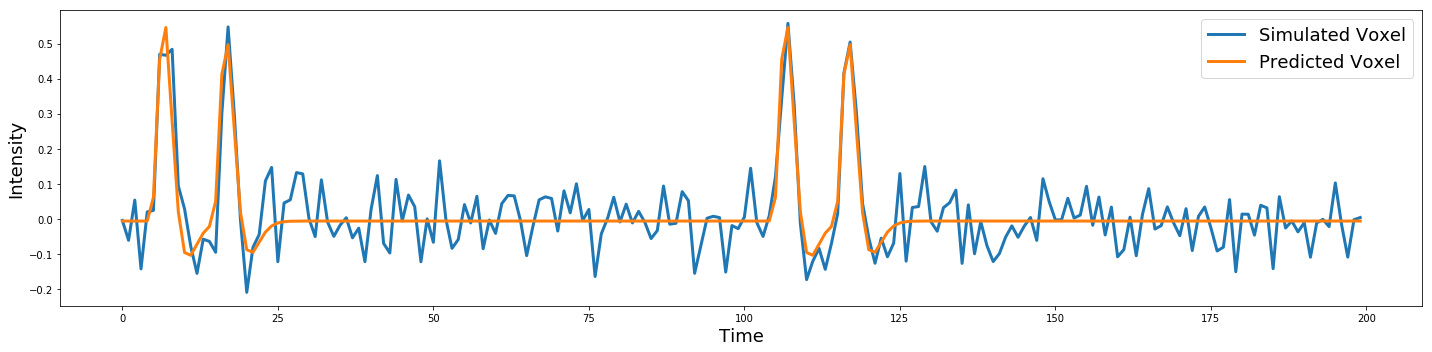

In [51]:
# Necessary redefinition to tell the notebook "r_square" isn't an int (grrrr dynamic typing...)
def r_square(Y, predicted_y):
    SS_total = np.sum((Y - np.mean(Y))**2)
    SS_residual = np.sum((Y - predicted_y)**2)
    return 1-(SS_residual/SS_total)

for n_trials in [5, 4, 3, 2]:    
    f = lambda : simulate_signal(2, 200, n_trials, ['face', 'object'], [1, 1], 10, 0, 0.05)
    beta, r_square, predicted_sigma, t, contrast_efficiencies = solutions.glm_analysis_beta(f, contrasts, plot=True)
    html = solutions.generate_results_html(['intercept','face','object'], contrasts, beta, r_square, contrast_efficiencies)
    display(HTML(f'n_trials={n_trials}' + html))

## Noise

How does the amount of noise in the data impact our contrast efficiency? Use your own implementation to check the results.

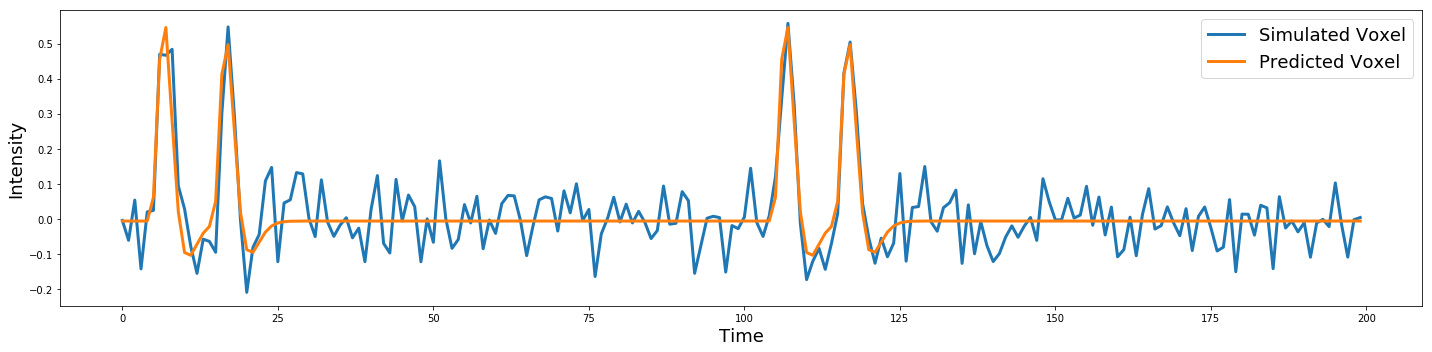

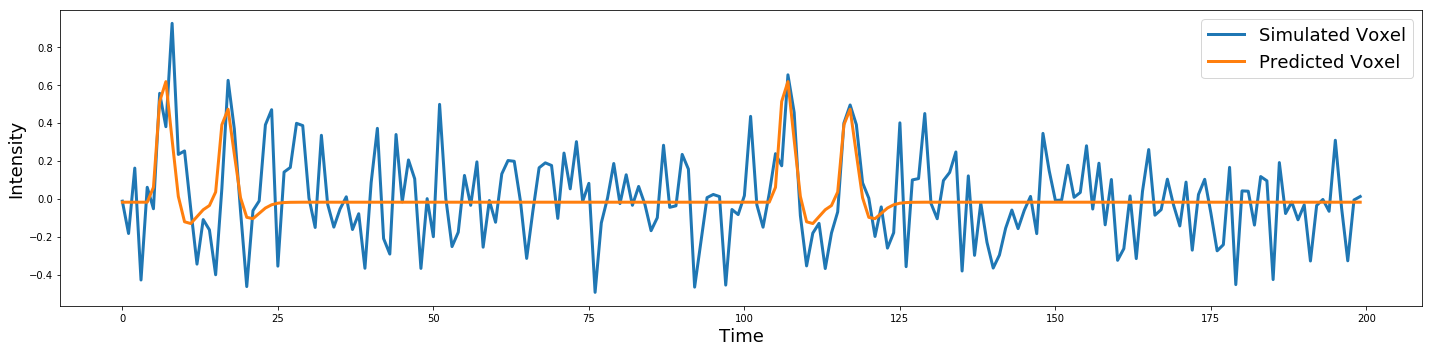

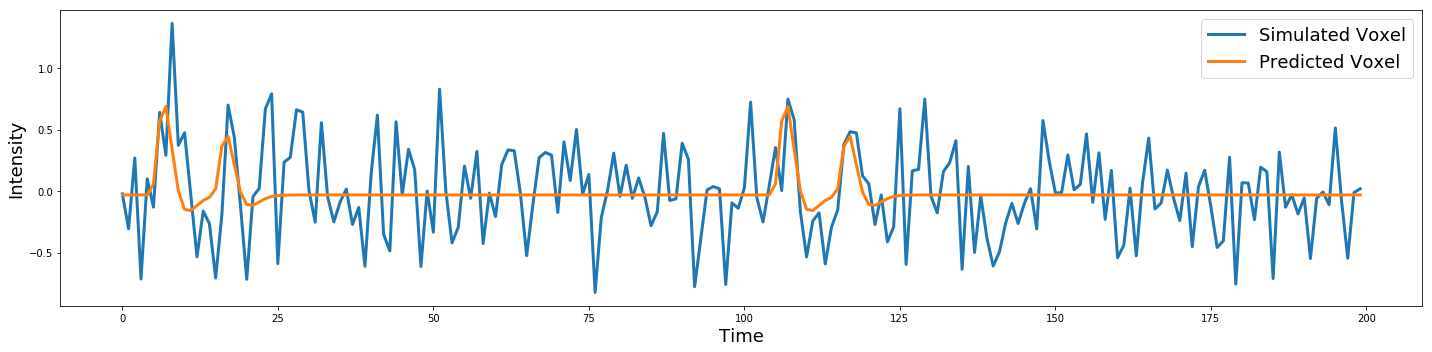

In [52]:
for noise_level in [0.05, 0.15, 0.25]:    
    f = lambda : simulate_signal(2, 200, n_trials, ['face', 'object'], [1, 1], 10, 0, noise_level)
    beta, r_square, predicted_sigma, t, contrast_efficiencies = solutions.glm_analysis_beta(f, contrasts, plot=True)
    html = solutions.generate_results_html(['intercept','face','object'], contrasts, beta, r_square, contrast_efficiencies)
    display(HTML(f'noise={noise_level}' + html))


## Amplitude

Some signals will be very strong and others weaker. How does the contrast efficiency change when the signal amplitudes are stronger and weaker? Make a plot showing how the contrast efficiency changes over 3 different levels of signal intensity (i.e., 1, 5, 10).

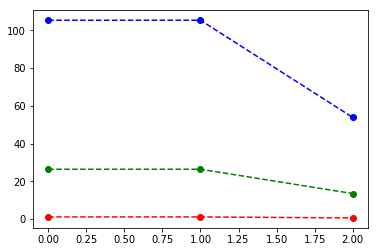

In [68]:
### BEGIN SOLUTION

# contrast_effs = []
styles = ['ro--', 'go--', 'bo--']
amplitudes = [1, 5, 10]
for i in [0, 1, 2]:   
    f = lambda : simulate_signal(2, 200, n_trials, ['face', 'object'], [amplitudes[i], amplitudes[i]], 10, 0, noise_level)
    beta, r_square, predicted_sigma, t, contrast_efficiencies = solutions.glm_analysis_beta(f, contrasts, plot=False)
    
    # contrast_effs.append(contrast_efficiencies)
    plt.plot(contrast_efficiencies, styles[i])

### END SOLUTION

## Durations

Write code like above to test the effects of varying durations of the 'face' event (1, 5, 10). You will need to use your implementation of `simulate_signal_plus` in order to set the duration of the face event to be longer than one. Make a plot showing what happens to the $\beta$ estimates.

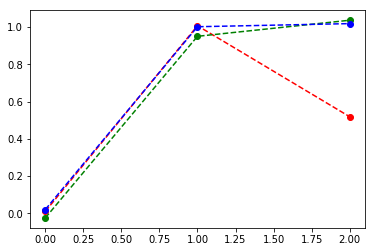

In [69]:
### BEGIN SOLUTION
styles = ['ro--', 'go--', 'bo--']
durations = [1, 5, 10]
for i in [0, 1, 2]:   
    f = lambda : simulate_signal_plus(2, 200, n_trials, ['face', 'object'], [1, 1], [durations[i], durations[i]], 10, 0, noise_level)
    beta, r_square, predicted_sigma, t, contrast_efficiencies = solutions.glm_analysis_beta(f, contrasts, plot=False)
    
    # contrast_effs.append(contrast_efficiencies)
    plt.plot(beta, styles[i])

### END SOLUTION

In [82]:
# In-class exercise to make a function that suggests an optimal amplitude given a target contrast efficiency

def suggest_optimal_amplitude(target_efficiency: int, n_trials=5, noise_level=0.15):
    # Assumes that contrast_efficiency increases with amplitude
    amplitudes = list(range(1, 1000))
    for i in amplitudes:   
        f = lambda : simulate_signal(2, 200, n_trials, ['face', 'object'], [i, 1], 10, 0, noise_level)
        beta, r_square, predicted_sigma, t, contrast_efficiencies = solutions.glm_analysis_beta(f, contrasts, plot=False)

        print(contrast_efficiencies)
        allMeetTarget = any((eff > target_efficiency) for eff in contrast_efficiencies)
        if (allMeetTarget):
            print("Optimal Amplitude:")
            return i



In [84]:
suggest_optimal_amplitude(1500)

[2.5536839996192415, 2.5536839996192415, 1.346576978451914]
[10.214735998476966, 2.5536839996192415, 2.13124350828219]
[22.98315599657319, 2.5536839996192424, 2.372019241004609]
[40.85894399390789, 2.5536839996192424, 2.4635035701760546]
[63.842099990481074, 2.5536839996192415, 2.5053673381006063]
[91.93262398629271, 2.5536839996192433, 2.5271101856543265]
[125.13051598134288, 2.553683999619243, 2.5394329035529464]
[163.43577597563157, 2.5536839996192415, 2.5468627682624456]
[206.84840396915862, 2.553683999619242, 2.551547103550243]
[255.36839996192435, 2.553683999619242, 2.55459693541222]
[308.9957639539284, 2.5536839996192424, 2.556627516250332]
[367.7304959451709, 2.553683999619242, 2.5579985682700292]
[431.5725959356519, 2.553683999619243, 2.5589299282231126]
[500.5220639253716, 2.5536839996192415, 2.559560957541978]
[574.5788999143301, 2.5536839996192415, 2.5599827572061633]
[653.7431039025258, 2.553683999619242, 2.5602564496308364]
[738.0146758899608, 2.553683999619242, 2.5604239

25

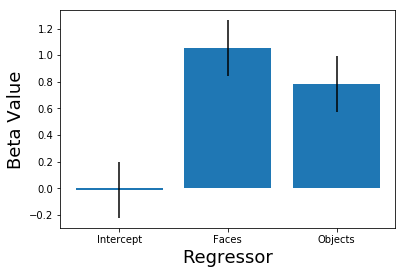

In [86]:
def next_exercise():
    plt.bar(['Intercept','Faces', 'Objects'], beta, yerr = predicted_sigma)
    plt.xlabel('Regressor', fontsize=18)
    plt.ylabel('Beta Value', fontsize=18)

next_exercise()